In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# activate R magic
%load_ext rpy2.ipython

# python libs
from google.colab import drive
#drive.mount('/content/drive')
from drive.MyDrive.SSA.utils import *


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from tqdm import tqdm
from pylab import rcParams
from matplotlib import rc
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr

import torch
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from copy import copy

#from r_functions import create, run

# some settings
%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 14, 10

RANDOM_SEED = 15
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
rpy2.robjects.numpy2ri.activate()
utils = importr('utils')
utils.chooseCRANmirror(ind=1)

#utils.install_packages('Rssa') # Rssa install;
rssa = importr('Rssa')

Загрузка файла. **filepath** - путь до файла. **SIZE** - размер ряда.

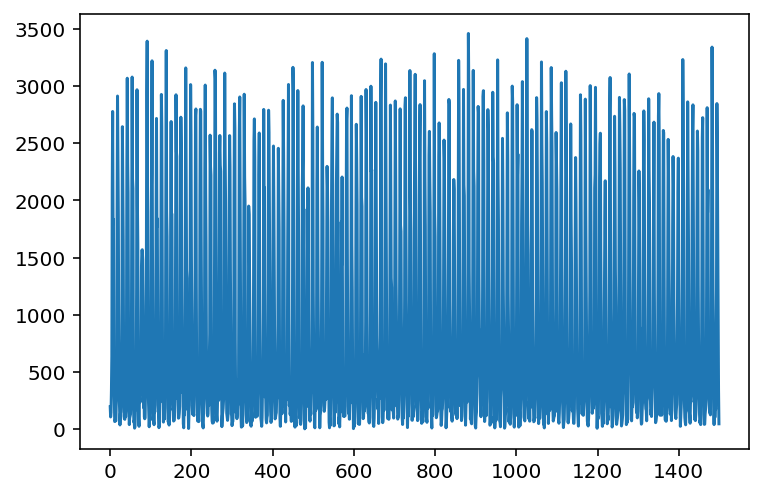

In [ ]:
filepath = "drive/MyDrive/SSA/rain_m.txt"

rain_df = pd.read_csv(filepath, sep = '\t', header=None)
rain = []
for i in range(146):
  rain = rain + [m for m in rain_df.iloc[i]] 

SIZE = 1500;
rain_m = np.array(rain[:SIZE])
plt.plot(rain_m);

Модуляция синуса. Ряд синуса длины **SIZE**.

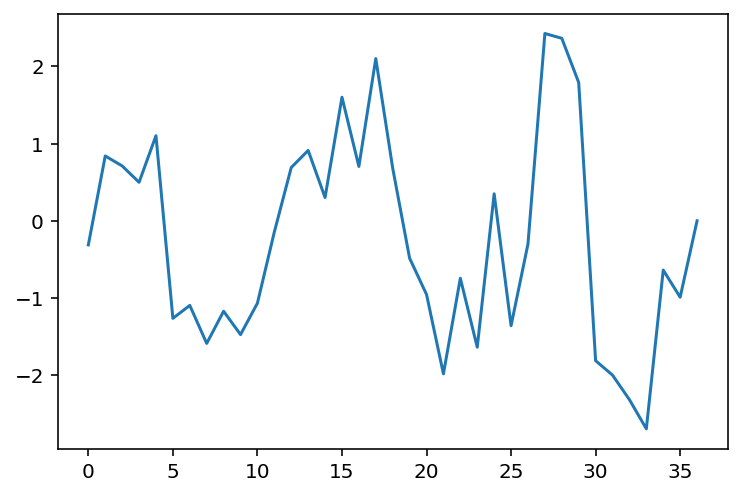

In [ ]:
# sin
np.random.seed(RANDOM_SEED)
T = 12

tsSin_sig = np.sin(np.arange(SIZE) * 2 * np.pi / T)
tsSin = tsSin_sig + 1*np.random.normal(size=SIZE)
plt.plot(tsSin[:37]);

Разбиение на **train**, **val** и **test**.  

data - словарь данных со следующими ключами:  
 - train
   - ts - часть временного ряда для выборки train (scaled).
   - X - "иксы" train выборки.
   - X_ssa - "иксы" train выборки, обработанные SSA.
   - y - "учитель" train выборки.
   - size - размер train выборки.
 - val
   - ts - часть временного ряда для выборки val (scaled).
   - X - "иксы" train выборки.
   - X_ssa - "иксы" val выборки, обработанные SSA (не используются на данный момент).
   - y - "учитель" val выборки.
   - size - размер val выборки.
 - test
   - ts - часть временного ряда для выборки test (scaled).
   - X - "иксы" test выборки.
   - y - "учитель" test выборки.
   - size - размер test выборки  
 - ts_scaled - изначальный временной ряд (scaled).
 - ts - изначальный временной ряд.
 - seq_len - размерность "обучающей" части траекторной матрицы.
 - scaler - объект типа **MinMaxScaler**.


In [ ]:
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 1000, 250, 250;
seq_len = 12;

assert TRAIN_SIZE + VAL_SIZE + TEST_SIZE == SIZE, "wrong TRAIN and VAL sizes"

ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : [1,2],
    'rssa' : rssa
})

# split_data
data = splitData(tsSin, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = True)
data_sig = splitData(tsSin_sig, seq_len, TRAIN_SIZE, VAL_SIZE, TEST_SIZE, ssa, val_ssa = False)

100%|██████████| 250/250 [06:49<00:00,  1.64s/it]


In [ ]:
class RainModel(nn.Module):

  def __init__(self, inputSize, hiddenLayer, outputSize):
    super(RainModel, self).__init__()
    self.linear1 = torch.nn.Linear(inputSize, hiddenLayer)
    self.linear2 = torch.nn.Linear(hiddenLayer, outputSize)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.sigmoid1 = nn.Sigmoid()


  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)    
    out = x

    return out

=============================================================  
=============================================================  

In [ ]:
RANDOM_SEED = 15

mArgs =  edict({
      'model_fun' : RainModel,
      'model_inits' : edict({
        'inputSize' : data.seq_len,
        'hiddenLayer' : 19,
        'outputSize' : 1
    })
})

kwargs = edict({
    'N_epochs' : 3000,
    'checkpoint' : 501,
    'X_train' : data.train.X,
    'y_train' : data.train.y,
    'X_val' : data.val.X,
    'y_val' : data.val.y,
    'model' : None
})

kwargs_raw_raw = copy(kwargs) 
kwargs_ssa_raw = copy(kwargs) 
kwargs_raw_ssa = copy(kwargs) 
kwargs_ssa_ssa = copy(kwargs) 
kwargs_signal_raw = copy(kwargs) 
kwargs_raw_signal = copy(kwargs) 
kwargs_signal_signal = copy(kwargs) 

raw X, raw y -> kwargs_raw.update({'X_train' : data.train.X })  
ssa X, raw y -> kwargs_ssa.update({'X_train' : data.train.X_ssa , 'X_val' : data.val.X_ssa})  
raw X, ssa y -> kwargs_ssa.update({'X_train' : data.train.X , 'y_train' : data.train.y_ssa, 'y_val' : data.val.y_ssa})  
ssa X, ssa y -> kwargs_ssa.update({'X_train' : data.train.X_ssa,  'y_train' : data.train.y_ssa, 'X_val' : data.val.X_ssa, 'y_val' : data.val.y_ssa})  
signal X, raw y -> kwargs_ssa.update({'X_train' : data_sig.train.X , 'X_val' : data_sig.val.X})  
raw X, signal y -> kwargs_signal.update({'X_train' : data.train.X , 'y_train' : data_sig.train.y, 'y_val' : data_sig.val.y})  
signal X, signal y -> kwargs_ssa.update({'X_train' : data_sig.train.X,  'y_train' : data_sig.train.y, 'X_val' : data_sig.val.X, 'y_val' : data_sig.val.y})

In [ ]:
kwargs_raw_raw.update({'X_train' : data.train.X })
kwargs_ssa_raw.update({'X_train' : data.train.X_ssa , 'X_val' : data.val.X_ssa})
kwargs_raw_ssa.update({'X_train' : data.train.X , 'y_train' : data.train.y_ssa, 'y_val' : data.val.y_ssa})
kwargs_ssa_ssa.update({'X_train' : data.train.X_ssa, 'y_train' : data.train.y_ssa, 'X_val' : data.val.X_ssa, 'y_val' : data.val.y_ssa})
kwargs_signal_raw.update({'X_train' : data_sig.train.X , 'X_val' : data_sig.val.X})
kwargs_raw_signal.update({'X_train' : data.train.X , 'y_train' : data_sig.train.y, 'y_val' : data_sig.val.y})
kwargs_signal_signal.update({'X_train' : data_sig.train.X, 'y_train' : data_sig.train.y, 'X_val' : data_sig.val.X, 'y_val' : data_sig.val.y})
#kwargs_raw.X_train, kwargs_ssa.X_train, kwargs_signal.X_train

In [ ]:
torch.manual_seed(RANDOM_SEED)
model_raw_raw, train_hist_raw_raw, val_hist_raw_raw = start_train(kwargs_raw_raw, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.24535055458545685 val loss: 0.2514759600162506
Epoch 501 train loss: 0.017024410888552666 val loss: 0.018132315948605537
Epoch 1002 train loss: 0.015612770803272724 val loss: 0.017073700204491615
Epoch 1503 train loss: 0.015131586231291294 val loss: 0.01709175668656826
Epoch 2004 train loss: 0.014761365018785 val loss: 0.017115112394094467
Epoch 2505 train loss: 0.01441177912056446 val loss: 0.017390115186572075

 Start to train raw model 

Epoch 0 train loss: 0.21335545182228088 val loss: 0.21898025274276733
Epoch 501 train loss: 0.01630348712205887 val loss: 0.01712893508374691
Epoch 1002 train loss: 0.015421321615576744 val loss: 0.01638897880911827


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_ssa_raw, train_hist_ssa_raw, val_hist_ssa_raw = start_train(kwargs_ssa_raw, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.24651965498924255 val loss: 0.25335684418678284
Epoch 501 train loss: 0.013855261728167534 val loss: 0.014899632893502712
Epoch 1002 train loss: 0.013844827190041542 val loss: 0.014905589632689953
Epoch 1503 train loss: 0.013835787773132324 val loss: 0.014914249069988728
Epoch 2004 train loss: 0.013827340677380562 val loss: 0.014921827241778374
Epoch 2505 train loss: 0.013821075670421124 val loss: 0.014933732338249683

 Start to train raw model 

Epoch 0 train loss: 0.2099556028842926 val loss: 0.2155342996120453
Epoch 501 train loss: 0.013851766474545002 val loss: 0.015013056807219982


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_raw_ssa, train_hist_raw_ssa, val_hist_raw_ssa = start_train(kwargs_raw_ssa, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.3441116213798523 val loss: 0.3250225782394409
Epoch 501 train loss: 0.020810527727007866 val loss: 0.022001665085554123
Epoch 1002 train loss: 0.019559336826205254 val loss: 0.020687947049736977
Epoch 1503 train loss: 0.018733998760581017 val loss: 0.02002434805035591
Epoch 2004 train loss: 0.017258934676647186 val loss: 0.018999651074409485
Epoch 2505 train loss: 0.016413500532507896 val loss: 0.018754608929157257

 Start to train raw model 

Epoch 0 train loss: 0.31691041588783264 val loss: 0.2976429760456085
Epoch 501 train loss: 0.019901305437088013 val loss: 0.021591559052467346
Epoch 1002 train loss: 0.018768496811389923 val loss: 0.02076639235019684
Epoch 1503 train loss: 0.018026644363999367 val loss: 0.019987678155303
Epoch 2004 train loss: 0.01646409183740616 val loss: 0.018858563154935837
Epoch 2505 train loss: 0.015712475404143333 val loss: 0.01847914606332779


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_ssa_ssa, train_hist_ssa_ssa, val_hist_ssa_ssa = start_train(kwargs_ssa_ssa, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.3462015390396118 val loss: 0.32684963941574097
Epoch 501 train loss: 3.862980520352721e-06 val loss: 1.3304454114404507e-05
Epoch 1002 train loss: 1.536469312668487e-06 val loss: 1.471977520850487e-05
Epoch 1503 train loss: 1.2731323977277498e-06 val loss: 1.5007597539806738e-05
Epoch 2004 train loss: 1.2121586223656777e-06 val loss: 1.5087229257915169e-05
Epoch 2505 train loss: 1.1892877864738693e-06 val loss: 1.5114850612008013e-05

 Start to train raw model 

Epoch 0 train loss: 0.32552629709243774 val loss: 0.3047022223472595


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_signal_raw, train_hist_signal_raw, val_hist_signal_raw = start_train(kwargs_signal_raw, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.24860388040542603 val loss: 0.2573162317276001
Epoch 501 train loss: 0.01386063639074564 val loss: 0.014876436442136765
Epoch 1002 train loss: 0.013842890039086342 val loss: 0.01488500740379095
Epoch 1503 train loss: 0.013828962109982967 val loss: 0.014894799329340458
Epoch 2004 train loss: 0.01382453553378582 val loss: 0.014902287162840366
Epoch 2505 train loss: 0.01382401306182146 val loss: 0.014911195263266563

 Start to train raw model 

Epoch 0 train loss: 0.2115987092256546 val loss: 0.21819308400154114


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_raw_signal, train_hist_raw_signal, val_hist_raw_signal = start_train(kwargs_raw_signal, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.37099161744117737 val loss: 0.3634570240974426
Epoch 501 train loss: 0.0264517180621624 val loss: 0.0313359834253788
Epoch 1002 train loss: 0.02524213306605816 val loss: 0.029985425993800163
Epoch 1503 train loss: 0.02384859323501587 val loss: 0.028575848788022995
Epoch 2004 train loss: 0.021480031311511993 val loss: 0.027422193437814713
Epoch 2505 train loss: 0.020223433151841164 val loss: 0.028210407122969627

 Start to train raw model 

Epoch 0 train loss: 0.34498170018196106 val loss: 0.3380633592605591
Epoch 501 train loss: 0.025759754702448845 val loss: 0.031031960621476173
Epoch 1002 train loss: 0.02428705058991909 val loss: 0.029647471383213997
Epoch 1503 train loss: 0.0231220331043005 val loss: 0.02840168960392475


In [ ]:
torch.manual_seed(RANDOM_SEED)
model_signal_signal, train_hist_signal_signal, val_hist_signal_signal = start_train(kwargs_signal_signal, mArgs, "raw")


Start to train raw model 

Epoch 0 train loss: 0.3771279454231262 val loss: 0.37194427847862244
Epoch 501 train loss: 1.9808394426945597e-06 val loss: 1.948620138136903e-06
Epoch 1002 train loss: 1.1616538131420384e-07 val loss: 1.1413764156031903e-07
Epoch 1503 train loss: 1.096345325635184e-08 val loss: 1.095803625617009e-08
Epoch 2004 train loss: 6.088524351355318e-09 val loss: 6.177900857551322e-09
Epoch 2505 train loss: 5.1076880502876065e-09 val loss: 5.183594886659648e-09

 Start to train raw model 

Epoch 0 train loss: 0.3606828451156616 val loss: 0.3559231162071228
Epoch 501 train loss: 2.3518137822975405e-05 val loss: 2.366139779041987e-05
Epoch 1002 train loss: 7.271398317243438e-06 val loss: 7.3432565841358155e-06
Epoch 1503 train loss: 1.3414977502179681e-06 val loss: 1.357673795610026e-06
Epoch 2004 train loss: 4.7239717559932615e-07 val loss: 4.784963039128343e-07
Epoch 2505 train loss: 2.6171332478952536e-07 val loss: 2.65357243733888e-07


Подстановка предсказаний:  
raw X, raw y -> getPredCases(model, data)  
ssa X, raw y -> getPredCases(model, data, ssa=ssa, ssa_ts=ssa_ts)

Подстановка истинных значений:  
raw X, raw y -> getPredCases(model, data, tomorrow=True, y_ssa=False)  
ssa X, raw y -> getPredCases(model, data, tomorrow = True, y_ssa=False, ssa = ssa)  
raw X, ssa y -> getPredCases(model, data, tomorrow = True, y_ssa=True)  
ssa X, ssa y -> getPredCases(model, data, tomorrow = True, y_ssa=True, ssa = ssa)

signal X, raw y -> getPredCases(model, data, tomorrow = data_sig, y_ssa=False)  
raw X, signal y -> getPredCases(model, data_sig, tomorrow = data, y_ssa=False)  
signal X, signal y -> getPredCases(model, data_sig, tomorrow = True, y_ssa=False)


In [ ]:
true_cases = tsSin[-TEST_SIZE:]

ssa_ts = data.ts[:(TRAIN_SIZE + VAL_SIZE)]
ssa = edict({
    'L' : TRAIN_SIZE//2,
    'ssa_groups' : [1,2],
    'rssa' : rssa
})

#predicted_cases_raw = getPredCases(model_raw, data, tomorrow=True, y_ssa=False)
#predicted_cases_ssa = getPredCases(model_ssa, data, tomorrow = True, y_ssa=False, ssa = ssa)
#predicted_cases_signal = getPredCases(model_signal, data, tomorrow = data_sig, y_ssa=False)

predicted_cases_raw_raw = getPredCases(model_raw_raw, data, tomorrow=True, y_ssa=False)
predicted_cases_ssa_raw = getPredCases(model_ssa_raw, data, tomorrow = True, y_ssa=False, ssa = ssa)
predicted_cases_raw_ssa = getPredCases(model_raw_ssa, data, tomorrow = True, y_ssa=True)
predicted_cases_ssa_ssa = getPredCases(model_ssa_ssa, data, tomorrow = True, y_ssa=True, ssa = ssa)
predicted_cases_signal_raw = getPredCases(model_signal_raw, data, tomorrow = data_sig, y_ssa=False)
predicted_cases_raw_signal = getPredCases(model_raw_signal, data_sig, tomorrow = data, y_ssa=False)
predicted_cases_signal_signal = getPredCases(model_signal_signal, data_sig, tomorrow = True, y_ssa=False)

100%|██████████| 250/250 [00:00<00:00, 6535.63it/s]


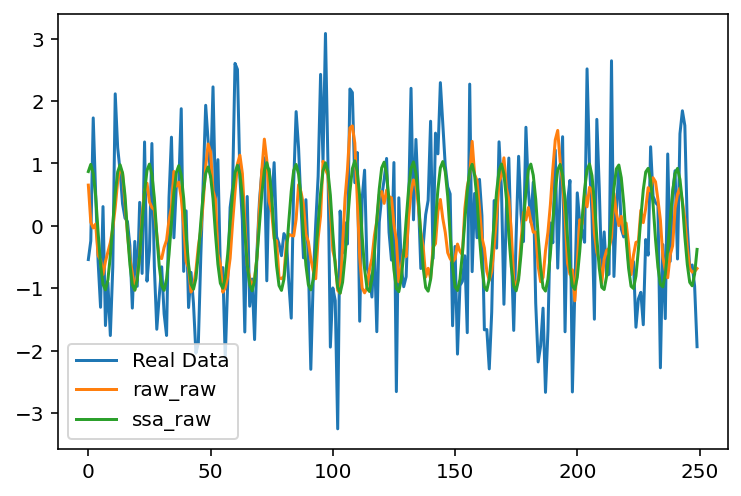

In [ ]:
cases = [true_cases, predicted_cases_raw_raw, predicted_cases_ssa_raw] # , predicted_cases_raw_ssa, predicted_cases_ssa_ssa, predicted_cases_signal_raw, predicted_cases_raw_signal, predicted_cases_signal_signal
labels = ['Real Data', 'raw_raw', 'ssa_raw'] # , 'raw_ssa', 'ssa_ssa','signal_raw','raw_signal','signal_signal'
plotNgraphs(cases, labels)

In [ ]:
np.sqrt(np.mean((true_cases - predicted_cases_raw_raw)**2)), np.sqrt(np.mean((true_cases - predicted_cases_ssa_raw)**2)), np.sqrt(np.mean((true_cases - predicted_cases_raw_ssa)**2))

(1.0527325750862322, 1.0026448341795624, 1.0282812948643718)

In [ ]:
import random
torch.manual_seed(RANDOM_SEED)
b = 10;
e = 150;
count = 10;

hl = []
for i in range(count):
  ran = random.randrange(b, e)
  if ran not in hl:
    hl.append(ran)
    print(ran)

results = []
for h in hl:
    kwargs_raw_raw = copy(kwargs)
    mArgs.update({'hiddenLayer' : h })
    model_raw_raw, train_hist_raw_raw, val_hist_raw_raw = start_train(kwargs_raw_raw, mArgs, "raw")
    predicted_cases_raw_raw = getPredCases(model_raw_raw, data, tomorrow=True, y_ssa=False)
    results.append(np.sqrt(np.mean((true_cases - predicted_cases_raw_raw)**2)))
  

90
103
67
145
19
97
109
84
70
59

Start to train raw model 

Epoch 0 train loss: 0.13389815390110016 val loss: 0.142051100730896
Epoch 501 train loss: 0.006928337272256613 val loss: 0.005240666680037975
Epoch 1002 train loss: 0.00616097217425704 val loss: 0.005152858793735504
Epoch 1503 train loss: 0.005760031286627054 val loss: 0.0051412335596978664
Epoch 2004 train loss: 0.005449584685266018 val loss: 0.0050798626616597176
Epoch 2505 train loss: 0.005076788365840912 val loss: 0.005012746434658766

 Start to train raw model 

Epoch 0 train loss: 0.12420357018709183 val loss: 0.13265593349933624
Epoch 501 train loss: 0.006941676139831543 val loss: 0.005346105899661779
Epoch 1002 train loss: 0.005896926857531071 val loss: 0.00494173401966691
Epoch 1503 train loss: 0.005323243327438831 val loss: 0.004853931255638599
Epoch 2004 train loss: 0.005005399696528912 val loss: 0.004946805536746979


100%|██████████| 100/100 [00:00<00:00, 6132.38it/s]



Start to train raw model 

Epoch 0 train loss: 0.07861091941595078 val loss: 0.083521768450737
Epoch 501 train loss: 0.006353979464620352 val loss: 0.0050020297057926655
Epoch 1002 train loss: 0.005332285072654486 val loss: 0.005142878741025925
Epoch 1503 train loss: 0.004721445497125387 val loss: 0.00538135739043355
Epoch 2004 train loss: 0.004279816057533026 val loss: 0.005660790950059891
Epoch 2505 train loss: 0.0039016446098685265 val loss: 0.006105758249759674

 Start to train raw model 

Epoch 0 train loss: 0.10890388488769531 val loss: 0.11656404286623001


100%|██████████| 100/100 [00:00<00:00, 6226.98it/s]

Epoch 501 train loss: 0.006459719501435757 val loss: 0.005164991598576307

Start to train raw model 

Epoch 0 train loss: 0.28993624448776245 val loss: 0.30491846799850464


Epoch 501 train loss: 0.007357539609074593 val loss: 0.005986777599900961
Epoch 1002 train loss: 0.006682009901851416 val loss: 0.005358316004276276
Epoch 1503 train loss: 0.006370937917381525 val loss: 0.005139308050274849
Epoch 2004 train loss: 0.006111199501901865 val loss: 0.0051225838251411915
Epoch 2505 train loss: 0.00578864524140954 val loss: 0.005188900511711836

 Start to train raw model 

Epoch 0 train loss: 0.19321751594543457 val loss: 0.20318739116191864
Epoch 501 train loss: 0.00738196587190032 val loss: 0.0058813137002289295
Epoch 1002 train loss: 0.006531525868922472 val loss: 0.005428240168839693
Epoch 1503 train loss: 0.005890730302780867 val loss: 0.0056722755543887615


100%|██████████| 100/100 [00:00<00:00, 6510.47it/s]



Start to train raw model 

Epoch 0 train loss: 0.195367693901062 val loss: 0.2035410851240158
Epoch 501 train loss: 0.007280572783201933 val loss: 0.005734733305871487
Epoch 1002 train loss: 0.006344197317957878 val loss: 0.005203252658247948
Epoch 1503 train loss: 0.005693285726010799 val loss: 0.005133934784680605
Epoch 2004 train loss: 0.00536242313683033 val loss: 0.005213889293372631
Epoch 2505 train loss: 0.004958015400916338 val loss: 0.005384914111346006

 Start to train raw model 

Epoch 0 train loss: 0.10853070765733719 val loss: 0.11484897136688232
Epoch 501 train loss: 0.006660426966845989 val loss: 0.005175108555704355
Epoch 1002 train loss: 0.005758744198828936 val loss: 0.00504960585385561


100%|██████████| 100/100 [00:00<00:00, 6280.87it/s]

Epoch 1503 train loss: 0.005264356732368469 val loss: 0.0052572451531887054

Start to train raw model 

Epoch 0 train loss: 0.13868427276611328 val loss: 0.14831623435020447


Epoch 501 train loss: 0.006864117458462715 val loss: 0.0049265362322330475
Epoch 1002 train loss: 0.005654528271406889 val loss: 0.004732336848974228
Epoch 1503 train loss: 0.005191393196582794 val loss: 0.005055513232946396
Epoch 2004 train loss: 0.004963441751897335 val loss: 0.00517157232388854
Epoch 2505 train loss: 0.004747974220663309 val loss: 0.005211603362113237

 Start to train raw model 

Epoch 0 train loss: 0.15895473957061768 val loss: 0.1695617139339447
Epoch 501 train loss: 0.006977415643632412 val loss: 0.005178375169634819


100%|██████████| 100/100 [00:00<00:00, 7063.26it/s]



Start to train raw model 

Epoch 0 train loss: 0.164892315864563 val loss: 0.1718692034482956
Epoch 501 train loss: 0.006716558244079351 val loss: 0.005171289201825857
Epoch 1002 train loss: 0.005875857081264257 val loss: 0.005195586476475
Epoch 1503 train loss: 0.005382925271987915 val loss: 0.005391175393015146
Epoch 2004 train loss: 0.0051170773804187775 val loss: 0.005353335291147232
Epoch 2505 train loss: 0.004869792144745588 val loss: 0.00545396376401186

 Start to train raw model 

Epoch 0 train loss: 0.1205238550901413 val loss: 0.12826208770275116


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 501 train loss: 0.006282558664679527 val loss: 0.005292840301990509


100%|██████████| 100/100 [00:00<00:00, 3871.93it/s]



Start to train raw model 

Epoch 0 train loss: 0.09982175379991531 val loss: 0.10648918151855469
Epoch 501 train loss: 0.0062827179208397865 val loss: 0.005141069181263447
Epoch 1002 train loss: 0.005347554571926594 val loss: 0.005185460671782494
Epoch 1503 train loss: 0.004805940669029951 val loss: 0.005497631151229143
Epoch 2004 train loss: 0.0043914904817938805 val loss: 0.005910394713282585
Epoch 2505 train loss: 0.003973265178501606 val loss: 0.006164079997688532

 Start to train raw model 

Epoch 0 train loss: 0.08374165743589401 val loss: 0.08938375860452652
Epoch 501 train loss: 0.006650389172136784 val loss: 0.0050751883536577225


100%|██████████| 100/100 [00:00<00:00, 6821.23it/s]



Start to train raw model 

Epoch 0 train loss: 0.11387762427330017 val loss: 0.12244728952646255
Epoch 501 train loss: 0.006912673823535442 val loss: 0.0052267443388700485
Epoch 1002 train loss: 0.006142714060842991 val loss: 0.004832959733903408
Epoch 1503 train loss: 0.005583344958722591 val loss: 0.0049178218469023705
Epoch 2004 train loss: 0.005049442406743765 val loss: 0.0051649827510118484
Epoch 2505 train loss: 0.0047062840312719345 val loss: 0.005478383973240852

 Start to train raw model 

Epoch 0 train loss: 0.2578149437904358 val loss: 0.2713325023651123
Epoch 501 train loss: 0.0073675308376550674 val loss: 0.005620282609015703


100%|██████████| 100/100 [00:00<00:00, 5691.20it/s]

Epoch 1002 train loss: 0.006591679994016886 val loss: 0.005134984385222197

Start to train raw model 

Epoch 0 train loss: 0.07178384810686111 val loss: 0.07658152282238007


Epoch 501 train loss: 0.006639608182013035 val loss: 0.005336356349289417
Epoch 1002 train loss: 0.005459498148411512 val loss: 0.005000834818929434
Epoch 1503 train loss: 0.00490786274895072 val loss: 0.005346254911273718
Epoch 2004 train loss: 0.0044416100718081 val loss: 0.005610574968159199
Epoch 2505 train loss: 0.0041217925027012825 val loss: 0.005821830593049526

 Start to train raw model 

Epoch 0 train loss: 0.13988982141017914 val loss: 0.14788690209388733
Epoch 501 train loss: 0.006787057034671307 val loss: 0.005291488487273455


100%|██████████| 100/100 [00:00<00:00, 5724.21it/s]

Epoch 1002 train loss: 0.005974723491817713 val loss: 0.0051376125775277615

Start to train raw model 

Epoch 0 train loss: 0.1477997750043869 val loss: 0.15733018517494202


Epoch 501 train loss: 0.006872628815472126 val loss: 0.005538919474929571
Epoch 1002 train loss: 0.005949606653302908 val loss: 0.00511881522834301
Epoch 1503 train loss: 0.0053050220012664795 val loss: 0.005210275296121836
Epoch 2004 train loss: 0.004969494417309761 val loss: 0.005471847951412201
Epoch 2505 train loss: 0.004624660592526197 val loss: 0.005684212315827608

 Start to train raw model 

Epoch 0 train loss: 0.1417209655046463 val loss: 0.14999090135097504
Epoch 501 train loss: 0.006432700902223587 val loss: 0.00510220555588603


100%|██████████| 100/100 [00:00<00:00, 5978.71it/s]

Epoch 1002 train loss: 0.005726332310587168 val loss: 0.005206032190471888


In [ ]:
min(results), results, hl[4]

(277.17888876641734,
 [301.91954803565164,
  287.5229240056807,
  278.80216984921367,
  279.5097465491251,
  277.17888876641734,
  282.9273376760519,
  281.13111837680856,
  277.54551188320033,
  282.25786946093365,
  287.3867562812788],
 19)

**FUNCTION createOneStepData:**  
  Создает словарь данных нужный для функции trainAndPredictOneStep в качестве аргумента.
  - input: словарь данных, полученный из splitData.
  - output: словарь для функции trainAndPredictOneStep.

**FUNCTION trainAndPredictOneStep:**  
Обучает модель и делает предсказание на 1 точку (ряда) вперед. Процедура повторяется, пока предсказанных точек не станет равным testSize. Возвращает все предсказанные точки.  
 - inputs:
    - N_epochs - количество эпох.
    - model - нейронная сеть.
    - data - словарь с данными (получается с помощью функции createOneStepData).
    - testSize - размер тестовой выборки.
    - ssa = None - словарь с данными для операций с SSA. Если не задан, то SSA в обучении не участвует.

 - outputs:
    - predictions - предсказания модели длиной testSize.


In [ ]:
oneStepData = createOneStepData(data)
preds_raw = trainAndPredictOneStep(100, RainModel(data.seq_len, 100, 1), oneStepData,
                               data.test.size, None)

100%|██████████| 250/250 [01:26<00:00,  2.90it/s]


In [ ]:
oneStepData = createOneStepData(data)
ssa = edict({
    'L' : 12,
    'ssa_groups' : [1,2],
    'rssa' : rssa
})
preds_ssa = trainAndPredictOneStep(100, RainModel(data.seq_len, 100, 1), oneStepData,
                               data.test.size, ssa)

100%|██████████| 250/250 [01:48<00:00,  2.30it/s]


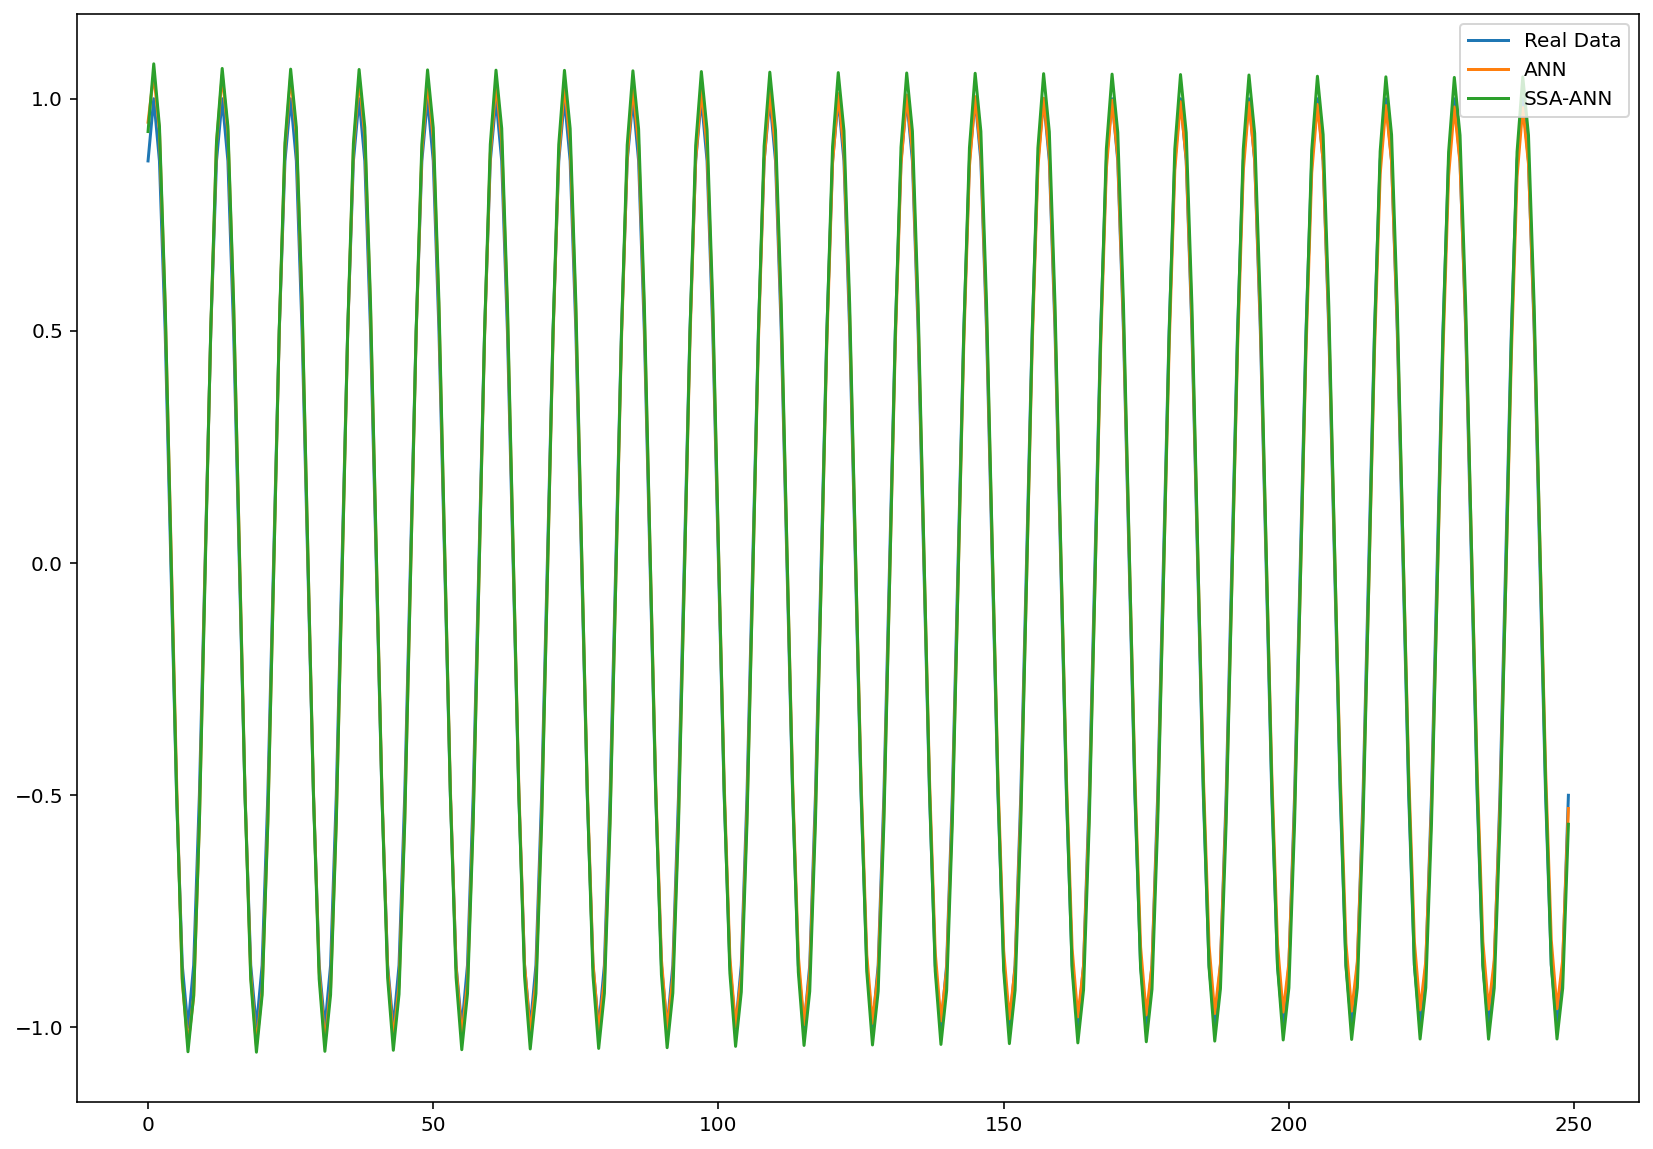

In [ ]:
plot3graphs(true_cases, preds_raw, preds_ssa)

In [ ]:
np.mean((true_cases - preds_raw)**2), np.mean((true_cases - preds_ssa)**2)

(0.0010783079827170138, 0.0020133165198634906)

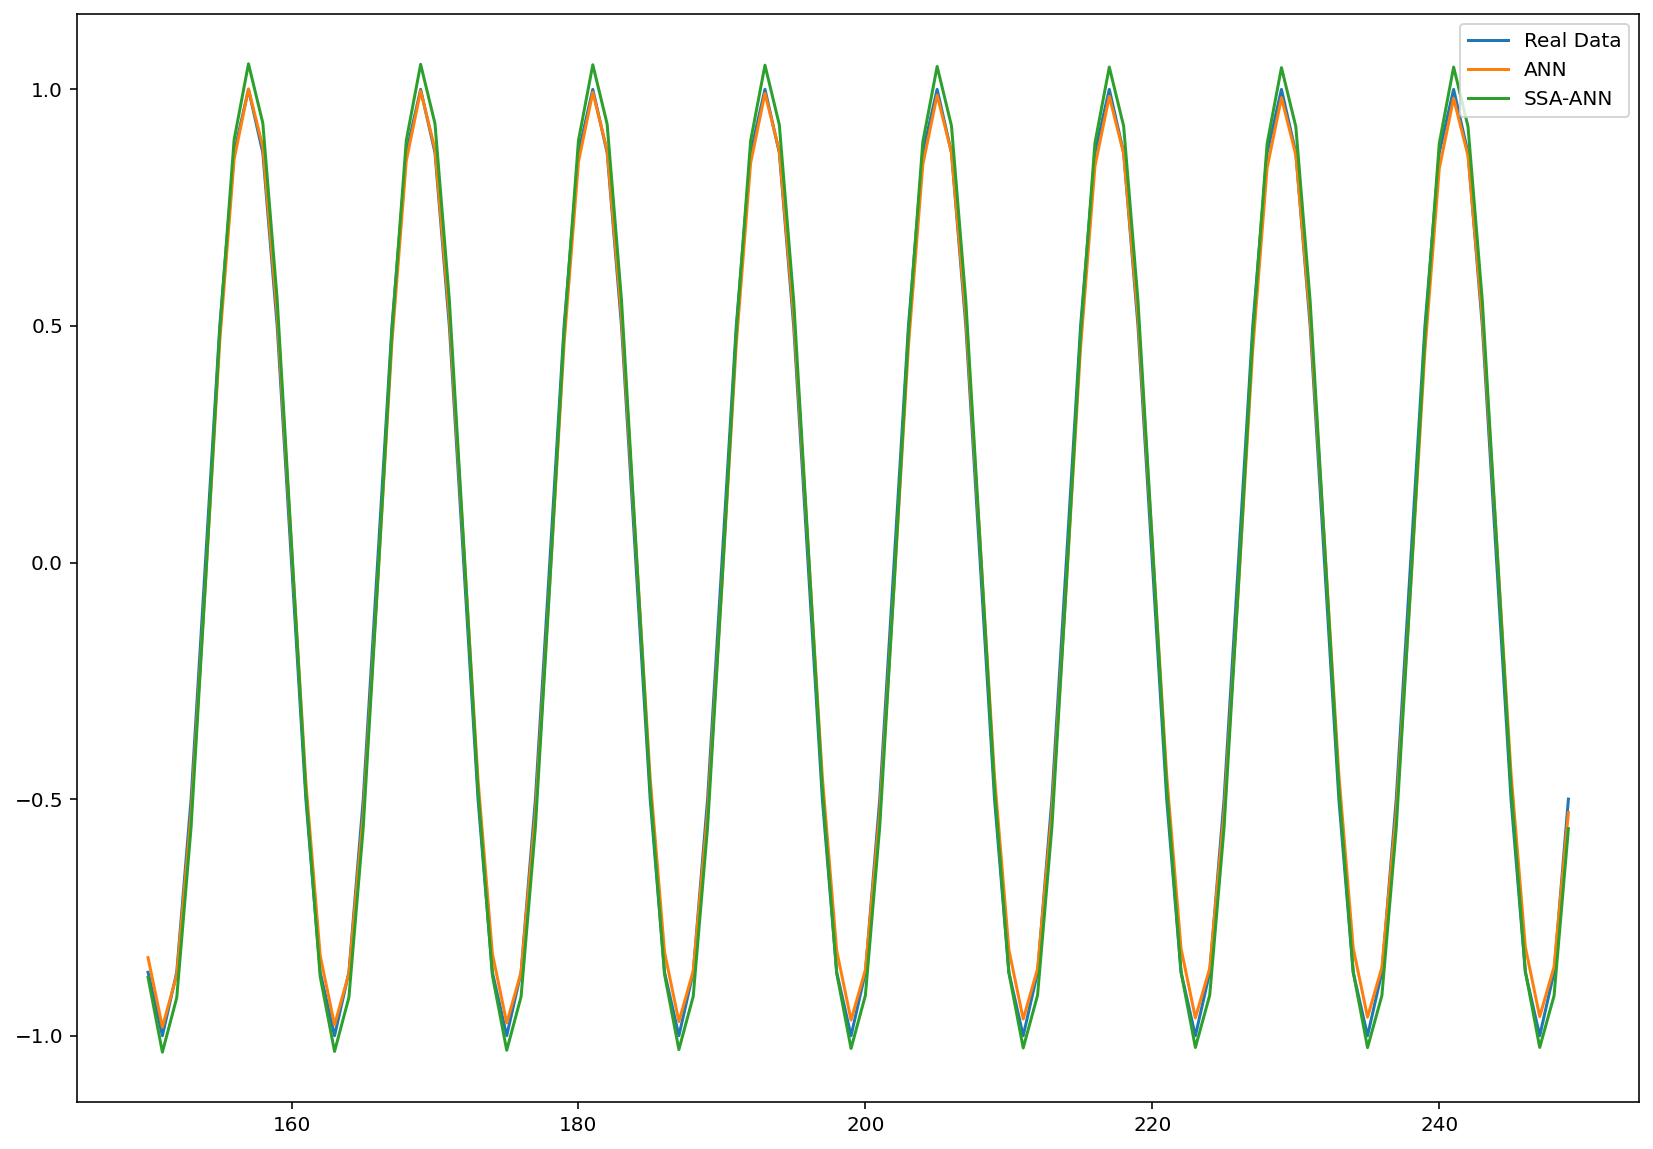

In [ ]:
plt.plot(
    np.arange(len(true_cases))[-100:],
    true_cases[-100:],
    label='Real Data'
  )

  # raw
plt.plot(
    np.arange(len(preds_raw))[-100:], 
    preds_raw[-100:], 
    label='ANN'
  )

  # ssa
plt.plot(
    np.arange(len(preds_ssa))[-100:], 
    preds_ssa[-100:], 
    label='SSA-ANN'
  )

plt.legend();